In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#from netCDF4 import Dataset 
#%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys, os
import numpy
import scipy
from scipy import signal

import seaborn as sns

import warnings
import math
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
#from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb # tig4.1
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.models import LinearMediation, Prediction
from tigramite.models import Models
from tigramite.toymodels import structural_causal_processes as toys

# import iris
# import iris.coord_categorisation as coord_cat
import pandas as pd
import xarray as xr

import matplotlib_inline
%config InlineBackend.figure_format='retina'

# from dask.diagnostics import ProgressBar


In [2]:
z500_GL_mean = xr.open_dataset('z500_GL_mean_ECEarth_2001-14.nc')['zg500']
t2m_EMed_mean = xr.open_dataset('t2m_EMed_mean_ECEarth_2001-14.nc')['tas']
t2m_UK_mean = xr.open_dataset('t2m_UK_mean_ECEarth_2001-14.nc')['tas']



# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic

##
## Optimizing pc_alpha over pc_alpha_list = [0.001, 0.005, 0.01, 0.025, 0.05]
##

## pc_alpha = 0.001 (1/5):

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.001]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Greenland Z500 has 1 link(s):
        (Greenland Z500 -1): max_pval = 0.00000, |min_val| =  0.338

    Variable EMed temp has 1 link(s):
        (EMed temp -1): max_pval = 0.00000, |min_val| =  0.241

    Variable UK temp has 2 link(s):
        (UK temp -1): max_pval = 0.00000, |min_val| =  0.339
        (UK temp -4): max_pval = 0.00001, |min_val| =  0.163

##
## Step 2: PC algorithm with contemp. conditions and MCI tests
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 8
pc_alpha = 0.001
contemp_collider

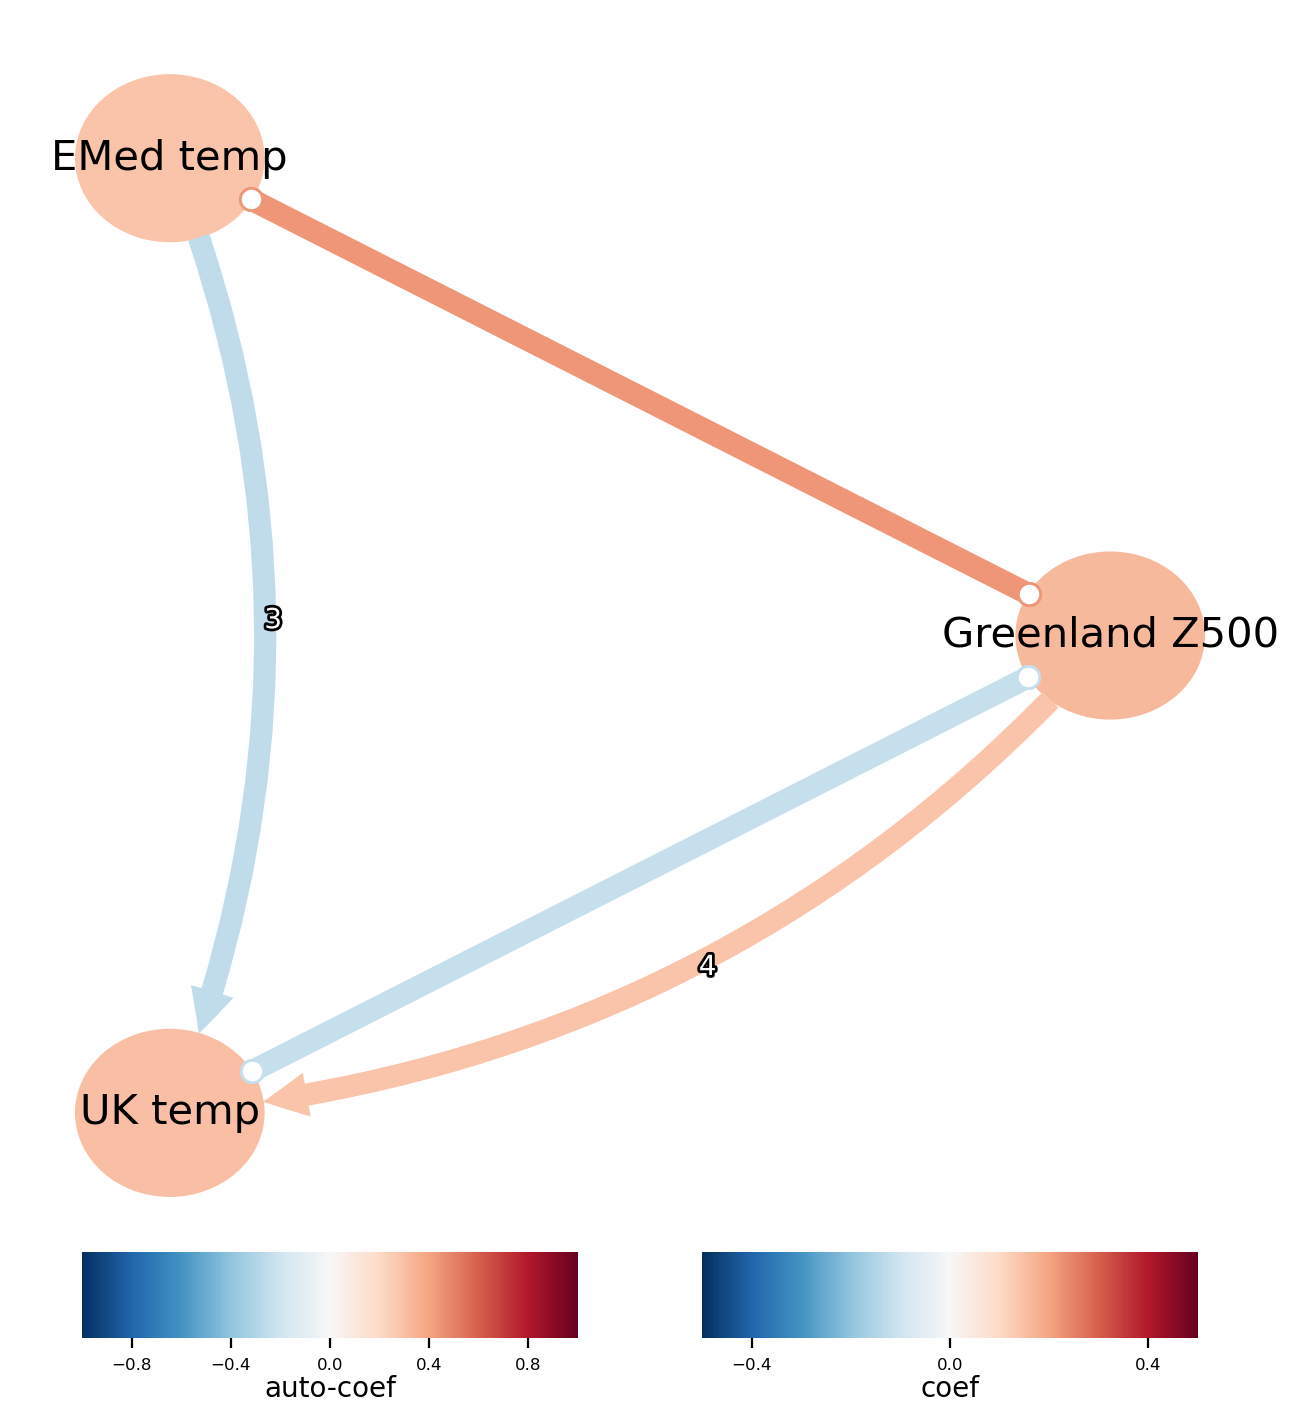

In [6]:
# Load datasets
# z500_GL_mean = iris.load_cube ('z500_GL_mean_ECEarth_2001-14.nc', 'zg500')
# t2m_EMed_mean = iris.load_cube ('t2m_EMed_mean_ECEarth_2001-14.nc', 'tas')
# t2m_UK_mean = iris.load_cube ('t2m_UK_mean_ECEarth_2001-14.nc', 'tas')
z500_GL_mean = xr.open_dataset('z500_GL_mean_ECEarth_2001-14.nc')['zg500']
t2m_EMed_mean = xr.open_dataset('t2m_EMed_mean_ECEarth_2001-14.nc')['tas']
t2m_UK_mean = xr.open_dataset('t2m_UK_mean_ECEarth_2001-14.nc')['tas']

# Standardise and detrend
z500_trend = z500_GL_mean - signal.detrend(z500_GL_mean.data)
z500_det = z500_GL_mean  - z500_trend
Z500 = (z500_det - np.mean(z500_det.data))/np.std(z500_det.data)
t2m_trend = t2m_EMed_mean - signal.detrend(t2m_EMed_mean.data)
t2m_det = t2m_EMed_mean  - t2m_trend
T2M_EMED = (t2m_det  - np.mean(t2m_det.data))/np.std(t2m_det.data)
t2m_trend = t2m_UK_mean - signal.detrend(t2m_UK_mean.data)
t2m_det = t2m_UK_mean  - t2m_trend
T2M_UK = (t2m_det  - np.mean(t2m_det.data))/np.std(t2m_det.data)

# PCMCI
data = np.array ([Z500.data, T2M_EMED.data, T2M_UK.data]).T
var_names = ['Greenland Z500', 'EMed temp', 'UK temp']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(T2M_EMED.data)), 
                         var_names=var_names)
			 #mask=data_mask

parcorr = ParCorr(significance='analytic', verbosity=1)
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
#correlations = pcmci.get_lagged_dependencies(tau_max=8, val_only=True)['val_matrix']
#pcmci.verbosity = 4
results = pcmci.run_pcmciplus(tau_max=8, pc_alpha=None)
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh', exclude_contemporaneous=False)
pcmci.print_significant_links(
        p_matrix = q_matrix, 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.01, tau_min=0, tau_max=8)
results['graph'] = graph
all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=True) # include_lagzero_parents=False
#pcmci.graph_to_dict(graph)  
print(all_parents)
link_matrix = graph

# Just let the model find the links
# Beta coefficient
from tigramite.models import Models
med = Models(dataframe=dataframe,            
             model = sklearn.linear_model.LinearRegression(),
            data_transform = None)    
med.fit_full_model(all_parents = all_parents, tau_max=8)           
Links = med.get_val_matrix()
# save Links
Links.dump('GBtoEMed_withUK_Pplus')       
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='coef',
    node_colorbar_label='auto-coef',
    figsize = [8,8],
    vmin_edges = -0.5,
    vmax_edges = 0.5,
    vmin_nodes = -1.0,
    vmax_nodes = 1.,
    cmap_nodes = 'RdBu_r',
    alpha = 1,
    node_label_size = 15,
    link_label_fontsize  = 10,
    show_autodependency_lags=False, save_name='GBtoEMed_WithUK_Pplus_ECEarth_allseasons.pdf')

# Constraining the links based on the observation
# Control with all parents
all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=True)
# Constrain the parents...
#['Greenland Z500', 'EMed temp', 'UK temp']
all_parents = {0: [(0, -1), (1, 0)], 1: [(1, -1),(0, 0)], 2: [(2, -1), (0, -2), (0, -1)]}
#link_matrix = graph

# initialise graph
graph = np.zeros((3,3,3),  dtype='<U3')
for i in range(3):
    for j in range(3):
        for tau in range(3):
            graph[i, j, tau] = ''
            
graph[0, 1, 0] = 'o-o'# '-->'
graph[1, 0, 0] = 'o-o'

graph[0, 0, 1] = '-->'
graph[1, 1, 1] = '-->'
graph[2, 2, 1] = '-->'
graph[0, 2, 2] = '-->'
graph[0, 2, 1] = '-->'

# Calculate beta coeff.
med = Models(dataframe=dataframe,            
             model = sklearn.linear_model.LinearRegression(),
             data_transform = None)    

med.fit_full_model(all_parents = all_parents, tau_max=8)     
      
Links = med.get_val_matrix()

Links[0,1,0] = Links[1,0,0]
Links[0,2,0] = Links[2,0,0]
Links[1,2,0] = Links[2,1,0]


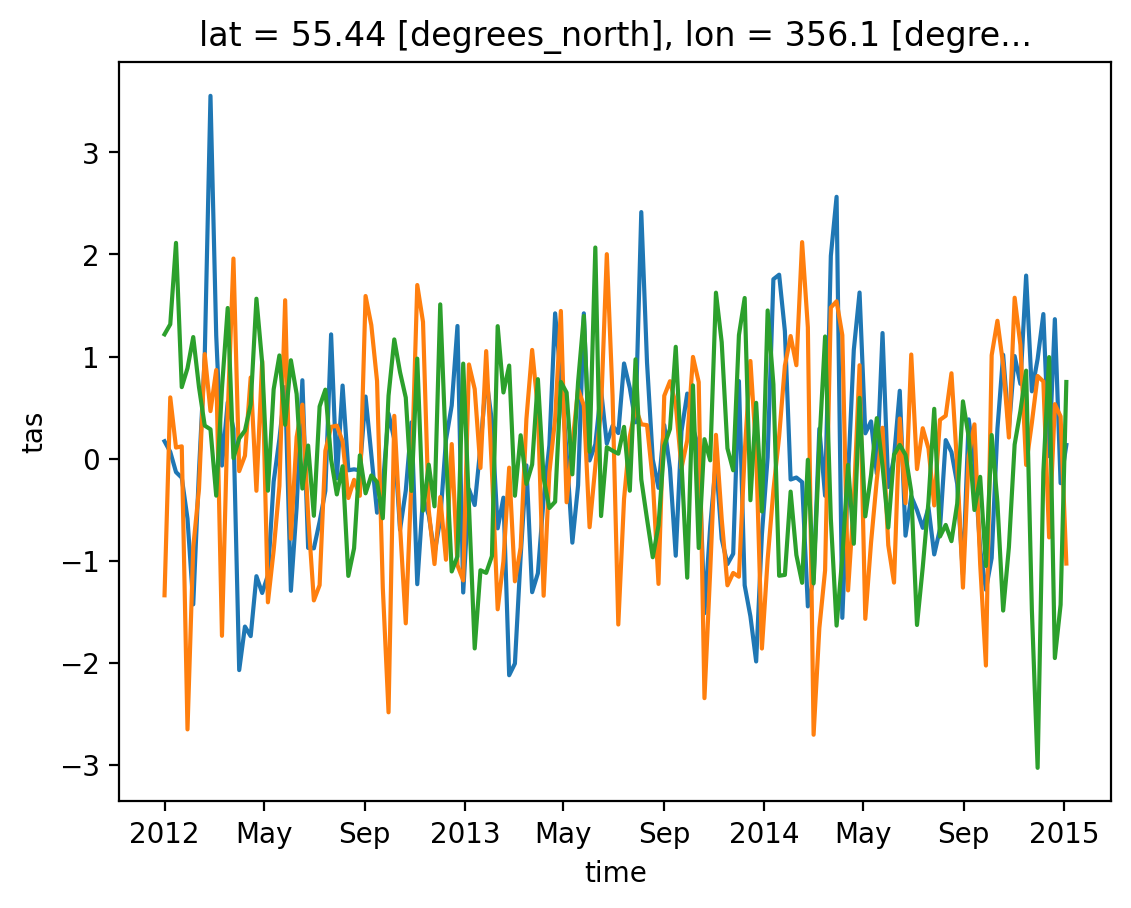

In [7]:
Z500.sel(time=slice('2012','2015')).plot()
T2M_EMED.sel(time=slice('2012','2015')).plot()
T2M_UK.sel(time=slice('2012','2015')).plot()


<Axes: xlabel='zg500', ylabel='tas'>

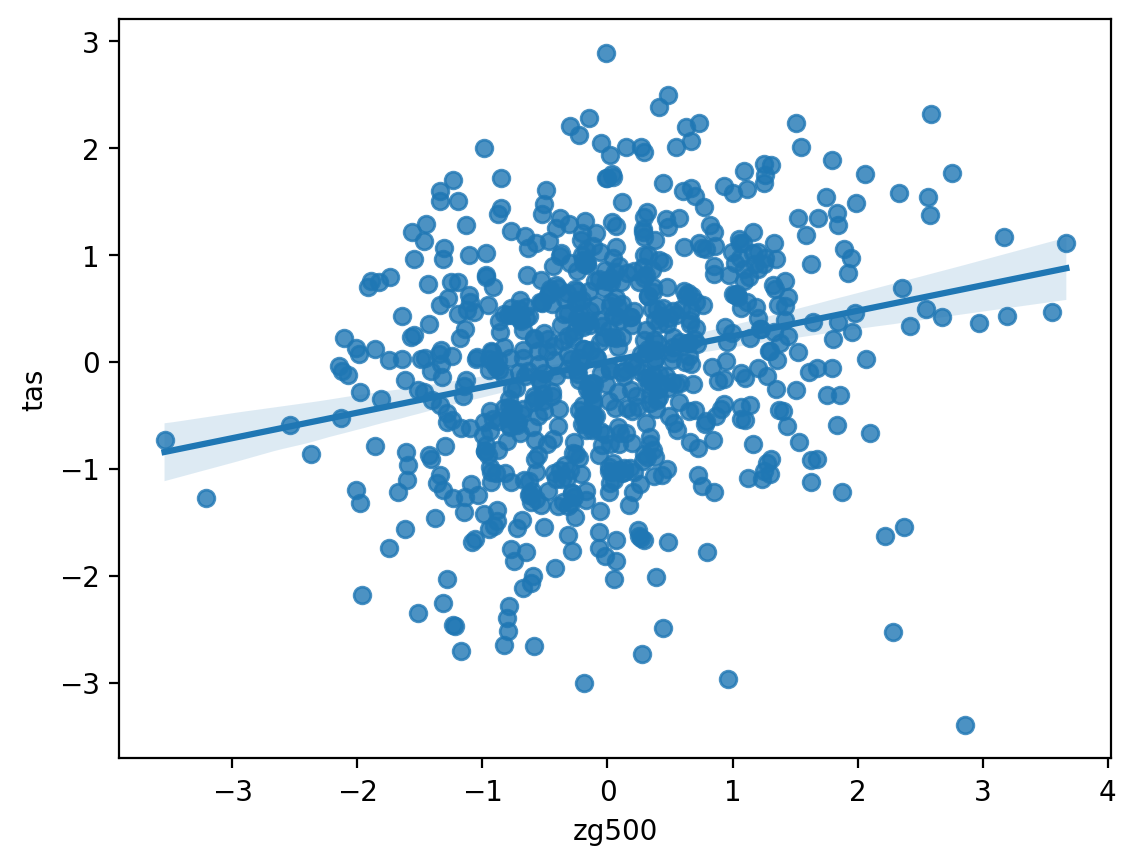

In [10]:
sns.regplot(x=Z500,y=T2M_EMED)


<Axes: xlabel='zg500', ylabel='tas'>

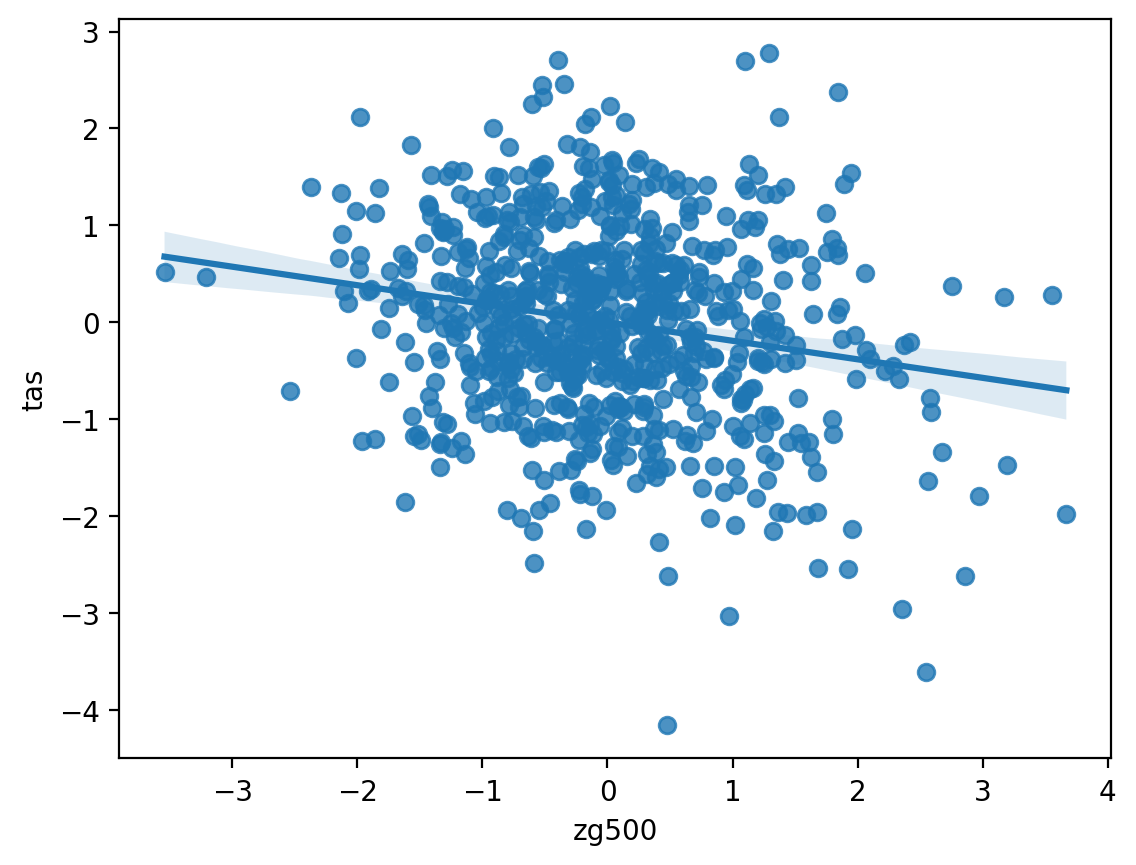

In [11]:
sns.regplot(x=Z500,y=T2M_UK)


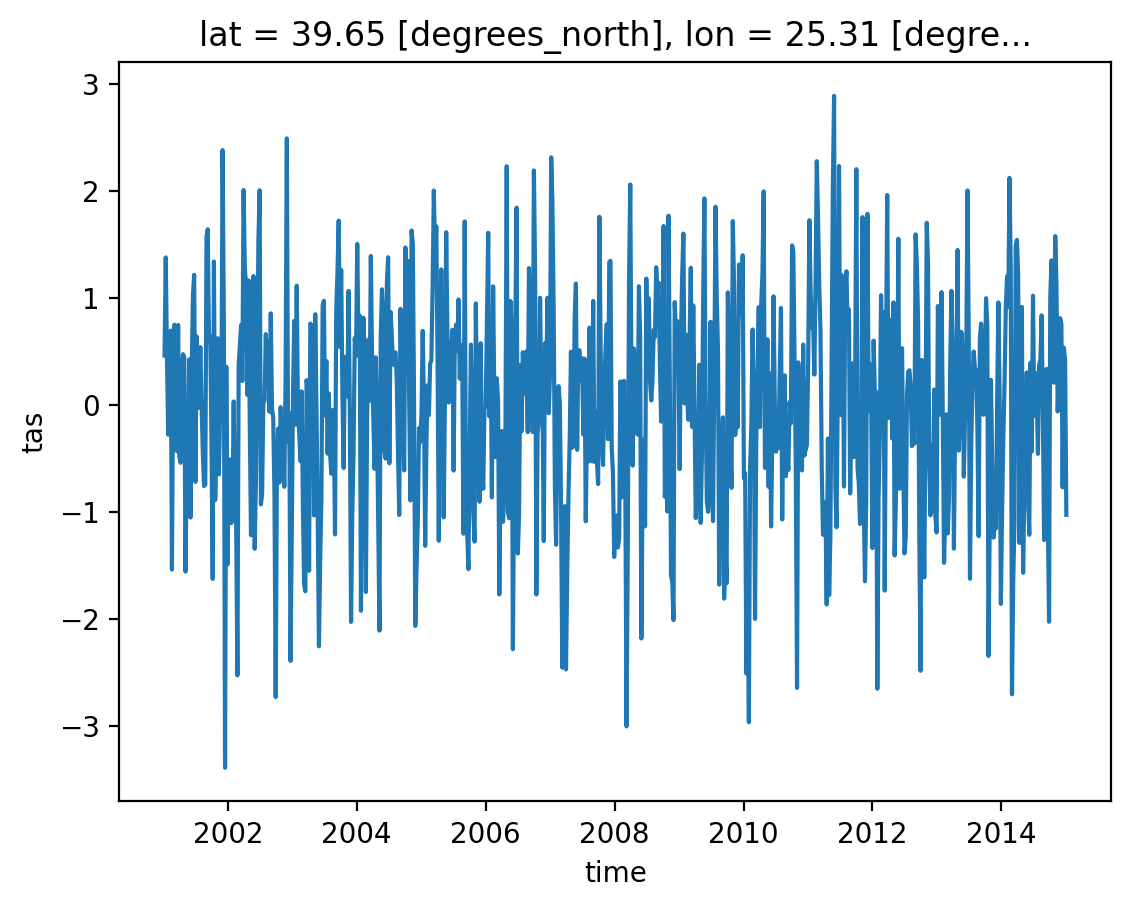

In [18]:
T2M_EMED.plot()


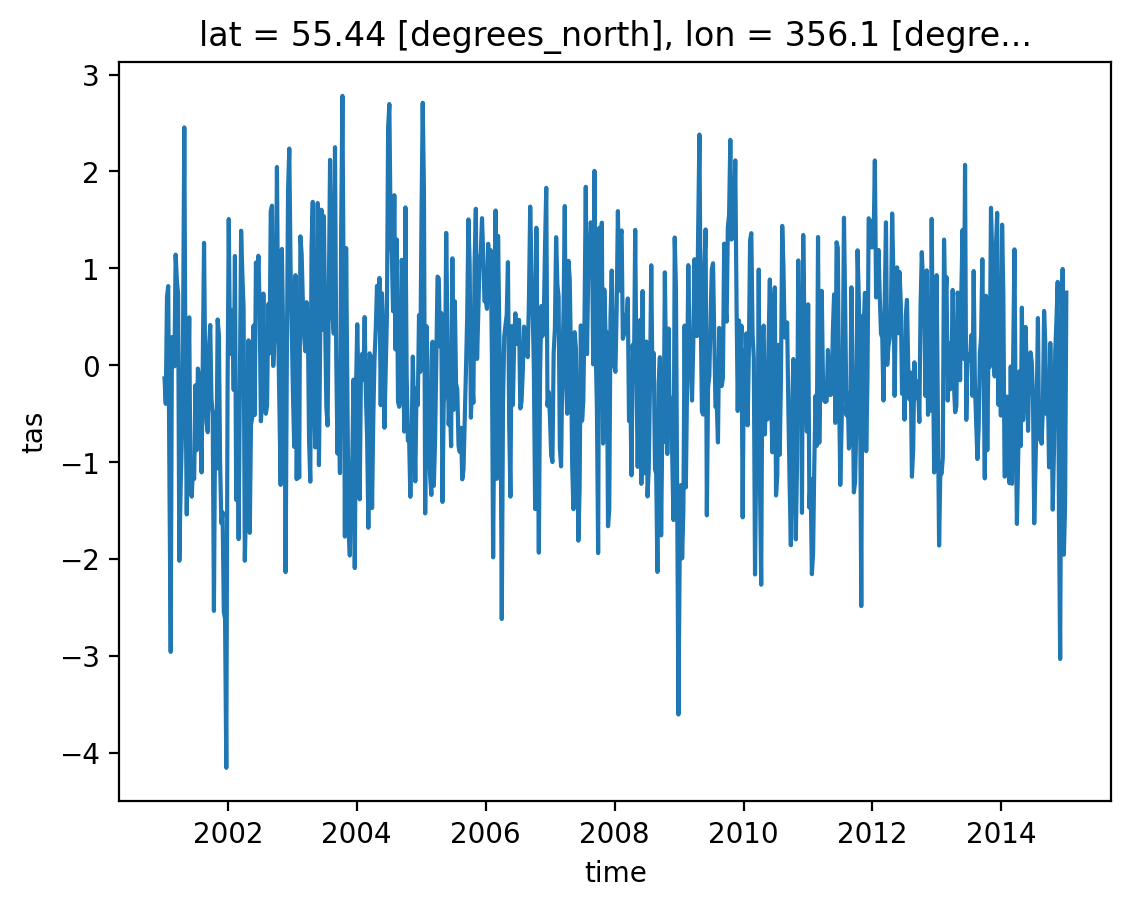

In [19]:
T2M_UK.plot()


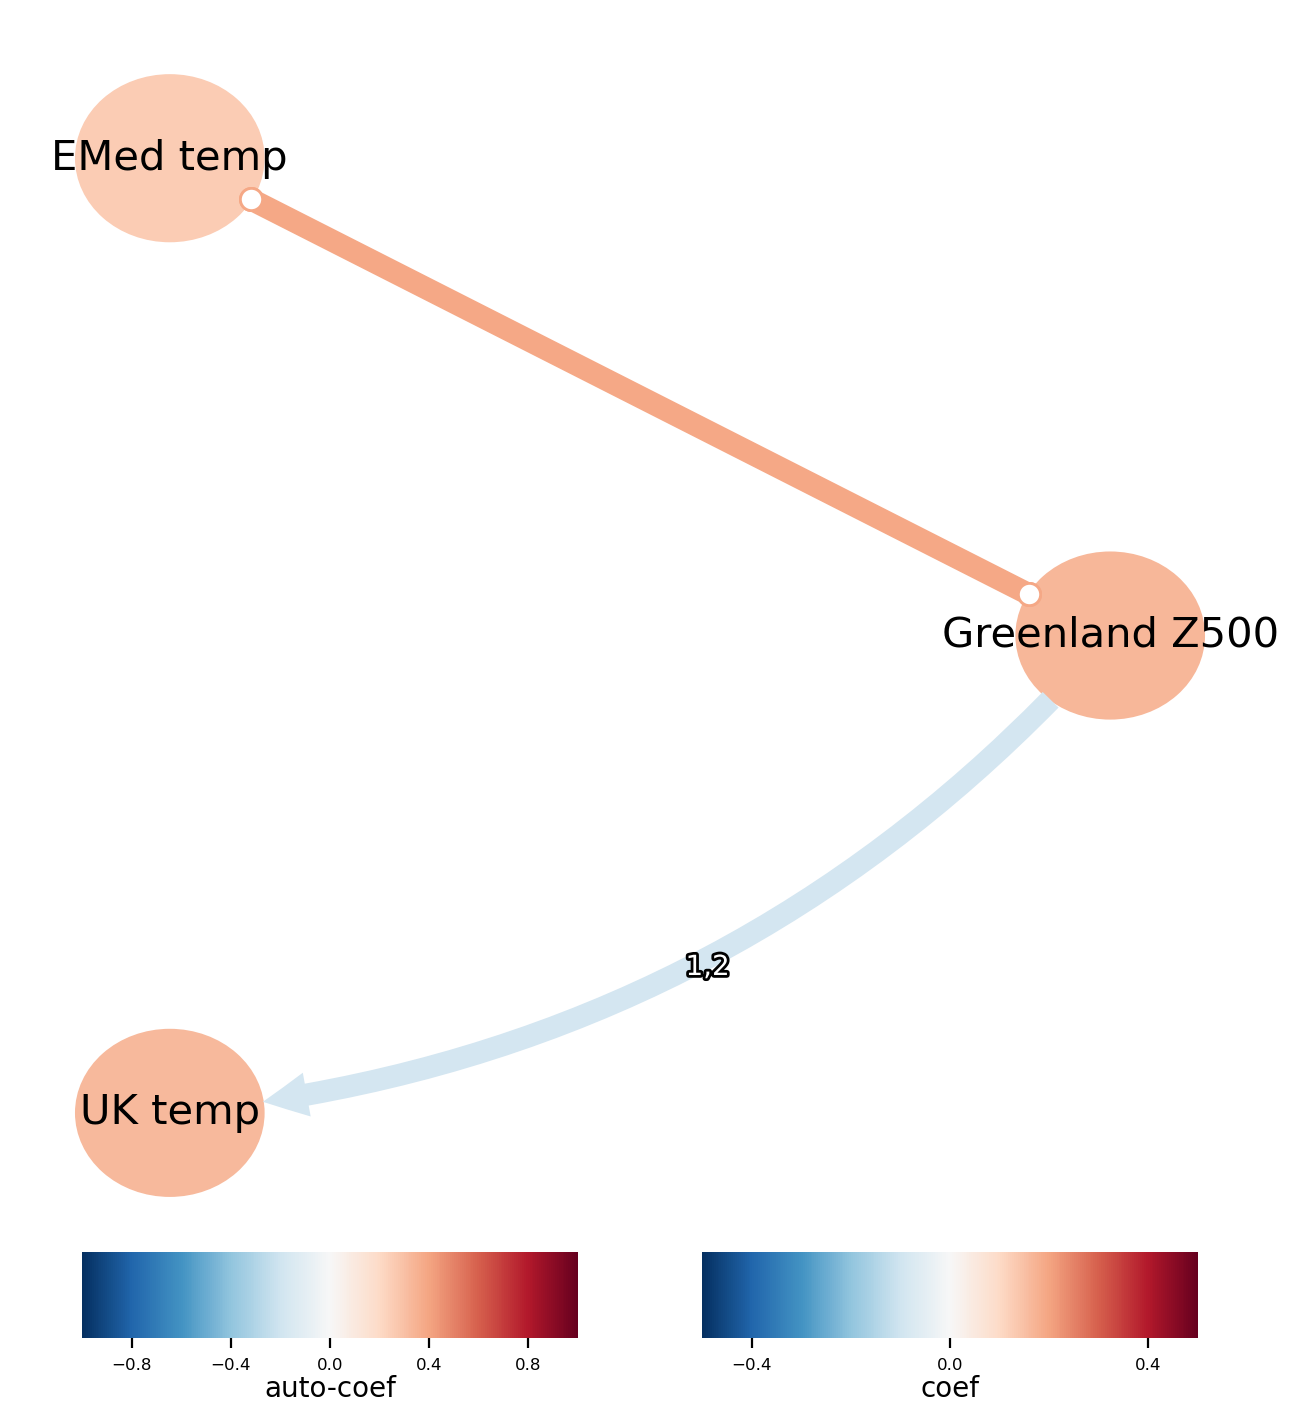

In [12]:
# save Links
Links.dump('GBtoEMed_WithUK_Pplus_constrainedlinks')

tp.plot_graph(
    val_matrix=Links,
    graph=graph,
    var_names=var_names,
    link_colorbar_label='coef',
    node_colorbar_label='auto-coef',
    figsize = [8,8],
    vmin_edges = -0.5,
    vmax_edges = 0.5,
    vmin_nodes = -1.0,
    vmax_nodes = 1.,
    cmap_nodes = 'RdBu_r',
    alpha = 1,
    node_label_size = 15,
    link_label_fontsize  = 10,
    show_autodependency_lags=False, save_name='GBtoEMed_WithUK_Pplus_constrainedlinks_ECEarth_allseasons.pdf')
